# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Code from the previous chapter

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [2]:
def make_system(beta1, gamma1, beta2, gamma2, t_b, pop):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init1 = State(S=(pop-1), I1=1, R1=0, I2=0, R2=0, Iboth=0, I12=0, I21=0, Rboth=0)
    seriesS = TimeSeries()
    seriesI = TimeSeries()
    seriesR = TimeSeries()
    #S: num people who didn't get either disease
    #I1: num people who are infected by disease A
    #R1: num people who recovered from disease A
    #I2: num people who are infected by disease B
    #R2: num people who recovered from disease B
    #Iboth: num people infected by both diseases
    #I12: num people recovered from disease A and got disease B
    #I21: num people recovered from disease B and got disease A
    #Rboth: num people who recovered from both diseases
    #seriesS: total num people susceptible 
    #seriesI: total num people infected
    #seriesR: total num people who recovered 
    
    init1 /= np.sum(init1)

    t0 = 0
    t_end = 7 * 14 * 2
    t_b = t_b
    #print(t_b)

    return System(init1=init1, t0=t0, t_end=t_end, t_b = t_b, pop = pop, seriesS=seriesS, seriesI=seriesI, seriesR=seriesR,
                  beta1=beta1, gamma1=gamma1, beta2=beta2, gamma2=gamma2, intersect_t=0, intersect=1)

In [20]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    return system.results.S[system.t0] - system.results.S[system.t_end]

In [8]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's an updated version of `run_simulation` that uses `unpack`.

In [9]:
def run_simulation(system):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init1.index)
    frame.loc[t0] = init1
    seriesS[t0] = init1.S
    seriesI[t0] = init1.I1
    seriesR[t0] = init1.R1
    
    for i in linrange(t0, t_end):
        if i < t_b:
            frame.loc[i+1] = update1(frame.loc[i], system, i)
        else:
            frame.loc[i+1] = update2(frame.loc[i], system, i)

    system.results = frame

In [10]:
def update1(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state

    infected1 = beta1 * i1 * s    
    recovered1 = gamma1 * i1
    
    s -= infected1
    i1 += infected1 - recovered1
    r1 += recovered1
    
    seriesS[i] = s 
    seriesI[i] = i1 
    seriesR[i] = r1 #since there is only one disease, people who recovered from it are in the recovered category
    
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

In [11]:
def update2(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state
    
    beta1offset1 = beta1 * 1.01 #beta1 + beta1/100
    beta1offset2 = beta1 * 0.99
    beta2offset1 = beta2 * 1.01
    beta2offset2 = beta2 * 0.99
    
    gamma1offset1 = gamma1 * 1.01
    gamma1offset2 = gamma1 * 0.99
    gamma2offset1 = gamma2 * 1.01
    gamma2offset2 = gamma2 * 0.99
    
#     beta1offset1 = beta1
#     beta1offset2 = beta1
#     beta2offset1 = beta2
#     beta2offset2 = beta2
    
#     gamma1offset1 = gamma1 
#     gamma1offset2 = gamma1 
#     gamma2offset1 = gamma2
#     gamma2offset2 = gamma2 
    
    if i == t_b:
        #at time t)b, we still have SIR model continuing for disease A with the addition of a fraction of the population infected by disease B
        infected1 = beta1 * i1 * s    
        recovered1 = gamma1 * i1
        infected2 = 10 / pop
        s -= (infected1 + infected2) 
        i2 += infected2
        i1 += (infected1 - recovered1)
        r1 += recovered1
        seriesS[i] = s + r1
        seriesI[i] = i1 + i2 
        seriesR[i] = rboth
        return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)
    
    infected1 = beta1*s*i1
    infected2 = beta2*s*i2
    recovered1 = gamma1*i1
    recovered2 = gamma2*i2
    infected1b = beta2offset1*i1*i2
    infected2b = beta1offset1*i1*i2
    infected12 = (beta2offset2*r1*(i2+iboth))
    infected21 = (beta1offset2*r2*(i1+iboth))
    recoveredbb = ((1/((1/gamma1)+(1/gamma2)))*iboth)
    recovered2b = gamma2offset1*i12
    recovered1b = gamma1offset1*i21
    
    s = s - (infected1 + infected2)
    if s < 0:
        s = 0
    
    i1 = i1 + infected1 - recovered1 - infected1b
    if i1 < 0:
        i1 = 0
        
    i2 = i2 + infected2 - recovered2 - infected2b
    if i2 < 0:
        i2 = 0
        
    iboth = iboth + infected1b + infected2b - recoveredbb
    if iboth < 0:
        iboth = 0
    
    r1 = r1 + recovered1 - infected12
    if r1 < 0:
        r1 = 0
    
    r2 = r2 + recovered2 - infected21
    if r2 < 0:
        r2 = 0
        
    i12 = i12 + infected12 - recovered2b
    if i12 < 0:
        i12 = 0
    
    i21 = i21 + infected21 - recovered1b
    if i21 < 0:
        i21 = 0
        
    rboth = rboth + recovered2b + recovered1b
    if rboth < 0:
        rboth = 0
        
#     if rboth > s and system.intersect == 1:
#         system.intersect_t = i
#         system.intersect = 0
        #print("intersect", system.intersect_t)
    
    if rboth > 0.5 and system.intersect == 1:
        system.intersect_t = i
        system.intersect = 0
        print("intersect", system.intersect_t)
    
    seriesS[i] = s + r1 + r2
    seriesI[i] = i1 + i2 + iboth + i12 + i21
    seriesR[i] = rboth
    
    #if seriesS[i] + seriesI[i] + seriesR[i] != 1:
       # print("something is wrong at ", i)
       # print(seriesS[i] + seriesI[i] + seriesR[i])
        
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

Test the updated code with this example.

In [75]:
tc1 = 3
tr1 = 4
tc2 = 3
tr2 = 4
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
system = make_system(beta1, gamma1, beta2, gamma2, 135, 90)
run_simulation(system)
system.results = system.results.dropna()
print(system.results)

            S            I1        R1        I2        R2         Iboth  \
0    0.988889  1.111111e-02  0.000000  0.000000  0.000000  0.000000e+00   
1    0.985226  1.199588e-02  0.002778  0.000000  0.000000  0.000000e+00   
2    0.981287  1.293647e-02  0.005777  0.000000  0.000000  0.000000e+00   
3    0.977055  1.393381e-02  0.009011  0.000000  0.000000  0.000000e+00   
4    0.972517  1.498839e-02  0.012494  0.000000  0.000000  0.000000e+00   
5    0.967658  1.610012e-02  0.016241  0.000000  0.000000  0.000000e+00   
6    0.962465  1.726823e-02  0.020266  0.000000  0.000000  0.000000e+00   
7    0.956925  1.849120e-02  0.024584  0.000000  0.000000  0.000000e+00   
8    0.951027  1.976663e-02  0.029206  0.000000  0.000000  0.000000e+00   
9    0.944761  2.109117e-02  0.034148  0.000000  0.000000  0.000000e+00   
10   0.938119  2.246041e-02  0.039421  0.000000  0.000000  0.000000e+00   
11   0.931095  2.386882e-02  0.045036  0.000000  0.000000  0.000000e+00   
12   0.923687  2.530967e-

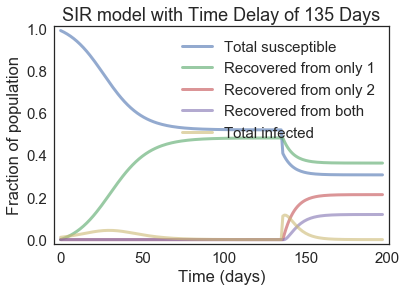

In [77]:
frame = system.results
plot(frame.S, label='Total susceptible')
plot(frame.R1, label='Recovered from only 1')
plot(frame.R2, label='Recovered from only 2')
plot(frame.Rboth, label="Recovered from both")
plot((frame.I1 + frame.I2 + frame.Iboth + frame.I12 + frame.I21), label="Total infected")
decorate(xlabel='Time (days)',
             ylabel='Fraction of population', title='SIR model with Time Delay of 135 Days')
#plot_results(system.seriesS, system.seriesI, system.seriesR)

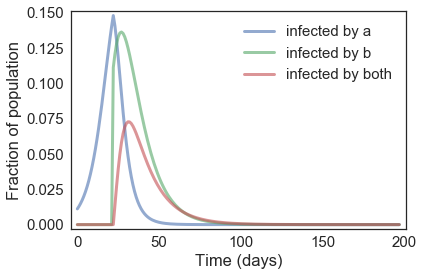

In [14]:
plot(frame.I1, label='infected by a')
plot(frame.I2, label='infected by b')
plot(frame.Iboth, label='infected by both')
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

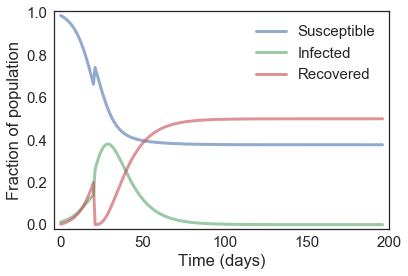

In [15]:
plot(system.seriesS, label='Susceptible')
plot(system.seriesI, label='Infected')
plot(system.seriesR, label='Recovered')
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [16]:
t_b_array = linrange(15, 35, 1)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    sweep[t_b] = system.intersect_t
    print(system.intersect_t)

0
0
0
0
0
0
0
intersect 88.0
88.0
intersect 81.0
81.0
intersect 79.0
79.0
intersect 79.0
79.0
intersect 79.0
79.0
intersect 81.0
81.0
intersect 84.0
84.0
intersect 89.0
89.0
intersect 98.0
98.0
0
0
0
0
0


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


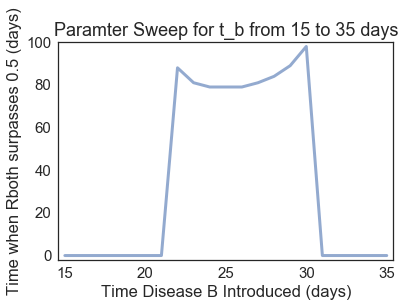

In [17]:
plot(sweep)
decorate(xlabel='Time Disease B Introduced (days)',
         ylabel='Time when Rboth surpasses 0.5 (days)', title='Paramter Sweep for t_b from 15 to 35 days')

In [62]:
tc1 = 3
tr1 = 4
tc2 = 3
tr2 = 4
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
t_b_array = linrange(5, 195, 5)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    #sweep[t_b] = system.results.S[system.t_end]
    sweep[t_b] = calc_total_infected(system)
    #sweep[t_b] = system.results.Rboth[system.t_end]
    #print (system.results.Rboth[system.t_end])
    print("total infected", calc_total_infected(system))


total infected 0.597828925833
total infected 0.597328245596
total infected 0.599253461436
total infected 0.60448887206
total infected 0.613015597731
total infected 0.623829004719
total infected 0.635414276131
total infected 0.646366591152
total infected 0.655780377297
total infected 0.663310757378
total infected 0.669023133426
total infected 0.673193630665
total infected 0.676157156875
total infected 0.678223766137
total infected 0.679646393033
total infected 0.680617112959
total infected 0.681275528644
total infected 0.681720315198
total infected 0.682019967538
total infected 0.682221467541
total infected 0.682356784165
total infected 0.682447547488
total infected 0.682508319212
total infected 0.682548829987
total infected 0.682575460949
total infected 0.68259214291
total infected 0.682600726176
total infected 0.682600699281
total infected 0.682587817681
total infected 0.682550549071
total infected 0.682461821008
total infected 0.682260414368
total infected 0.681809348012
total infect

In [69]:
print(sweep.idxmax())
print(sweep.max())

135
0.682600726176


In [70]:
tc1 = 3
tr1 = 4
tc2 = 2
tr2 = 5
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
t_b_array = linrange(5, 195, 5)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    #sweep[t_b] = system.results.S[system.t_end]
    sweep[t_b] = calc_total_infected(system)
    #sweep[t_b] = system.results.Rboth[system.t_end]
    #print (system.results.Rboth[system.t_end])
    print("total infected", calc_total_infected(system))

total infected 0.898916204335
total infected 0.89100595535
total infected 0.880917586877
total infected 0.869224571079
total infected 0.857196316555
total infected 0.846375819501
total infected 0.837868621134
total infected 0.831942728936
total infected 0.828197591952
total infected 0.825988922396
total infected 0.824739388389
total infected 0.824044572788
total infected 0.823657347898
total infected 0.823438008706
total infected 0.823310668131
total infected 0.823234642203
total infected 0.823187972613
total infected 0.823158545218
total infected 0.823139437592
total infected 0.823126478622
total infected 0.82311691667
total infected 0.823108605246
total infected 0.82309936607
total infected 0.823086280137
total infected 0.823064634677
total infected 0.823026115963
total infected 0.822955533085
total infected 0.822824764479
total infected 0.822581495822
total infected 0.822128200281
total infected 0.821282802875
total infected 0.81970481043
total infected 0.816755883711
total infected

In [71]:
print(sweep[100])

0.823126478622


In [73]:
tc1 = 3
tr1 = 4
tc2 = 5
tr2 = 2
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
t_b_array = linrange(5, 195, 5)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    #sweep[t_b] = system.results.S[system.t_end]
    sweep[t_b] = calc_total_infected(system)
    #sweep[t_b] = system.results.Rboth[system.t_end]
    #print (system.results.Rboth[system.t_end])
    print("total infected", t_b, calc_total_infected(system))

total infected 5.0 0.394999105096
total infected 10.0 0.41393753768
total infected 15.0 0.435851246553
total infected 20.0 0.459806478745
total infected 25.0 0.48446686285
total infected 30.0 0.508302545932
total infected 35.0 0.529903341249
total infected 40.0 0.548291917372
total infected 45.0 0.563083210724
total infected 50.0 0.574424614006
total infected 55.0 0.582796337039
total infected 60.0 0.588800923373
total infected 65.0 0.59301847072
total infected 70.0 0.595937147678
total infected 75.0 0.597936172849
total infected 80.0 0.599295610374
total infected 85.0 0.600215619259
total infected 90.0 0.600836195732
total infected 95.0 0.601253865545
total infected 100.0 0.601534551307
total infected 105.0 0.601722989988
total infected 110.0 0.601849412776
total infected 115.0 0.601934190602
total infected 120.0 0.601991024111
total infected 125.0 0.60202911606
total infected 130.0 0.602054642678
total infected 135.0 0.602071746609
total infected 140.0 0.602083205387
total infected 1

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


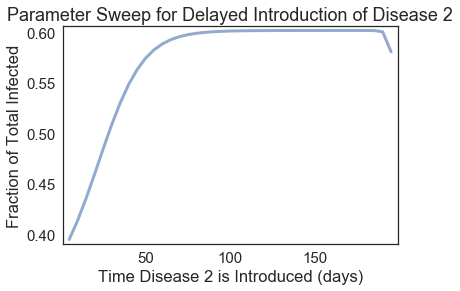

In [74]:
plot(sweep)
decorate(xlabel='Time Disease 2 is Introduced (days)',
         ylabel='Fraction of Total Infected', title='Parameter Sweep for Delayed Introduction of Disease 2')

In [44]:
tc1 = 3
tr1 = 5
tc2 = 3
tr2 = 5
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
t_b_array = linrange(5, 100, 5)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    sweep[t_b] = system.results.Rboth[system.t_end]
    print (system.results.Rboth[system.t_end])


0.117638869566
0.167304030225
0.203099698211
0.217178674183
0.216259362236
0.208657561884
0.198472832479
0.1880413367
0.179032726628
0.172179281367
0.167405268033
0.164266254665
0.162276123923
0.161042459591
0.160288146737
0.159830744599
0.159554766729
0.15938874673
0.1592890391
0.159229187514


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


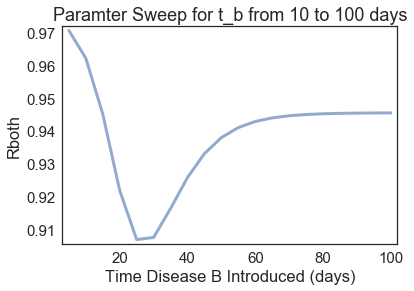

In [23]:
plot(sweep)
decorate(xlabel='Time Disease B Introduced (days)',
         ylabel='Rboth', title='Paramter Sweep for t_b from 10 to 100 days')

In [36]:
tc1 = 3
tr1 = 4
tc2 = 2
tr2 = 6
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
t_b_array = linrange(5, 100, 5)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    sweep[t_b] = system.results.Rboth[system.t_end]
    print (system.results.Rboth[system.t_end])

0.0820405303894
0.122100095826
0.166706376036
0.211444062465
0.251516933056
0.283472634581
0.306205279217
0.320739653433
0.329190942114
0.333720389649
0.335983993148
0.337045783471
0.337512112619
0.337700078005
0.337765100336
0.337779331199
0.33777442946
0.337763140587
0.33774952347
0.337733424854


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


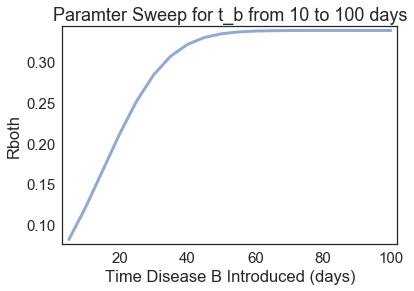

In [37]:
plot(sweep)
decorate(xlabel='Time Disease B Introduced (days)',
         ylabel='Rboth', title='Paramter Sweep for t_b from 10 to 100 days')

In [38]:
tc1 = 3
tr1 = 4
tc2 = 5
tr2 = 2
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
t_b_array = linrange(5, 100, 5)
sweep = SweepSeries()
for t_b in t_b_array:
    system = make_system(beta1, gamma1, beta2, gamma2, t_b, 90)
    run_simulation(system)
    sweep[t_b] = system.results.Rboth[system.t_end]
    print (system.results.Rboth[system.t_end])

0.0416531240285
0.0416487235887
0.0412676155914
0.0404199762196
0.0390834947756
0.0373203061959
0.0352809422255
0.033175770974
0.0312108808423
0.0295271791937
0.028179970727
0.02715684648
0.0264090188681
0.0258771179796
0.0255059379051
0.0252502944537
0.0250757968855
0.0249574108167
0.0248774226808
0.0248235278316


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


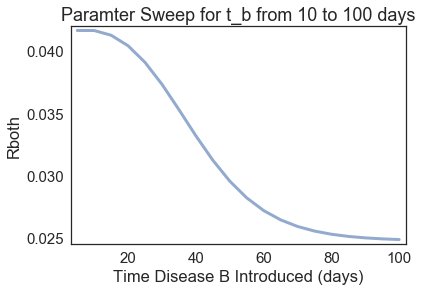

In [39]:
plot(sweep)
decorate(xlabel='Time Disease B Introduced (days)',
         ylabel='Rboth', title='Paramter Sweep for t_b from 10 to 100 days')